To implement:  
- [x] Galsim shear transormation of an image  
- [ ] Shear transformation given jac matrix in tensorflow
- [ ] Jacobian computation given given shear parameters

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


## GalSim transformation

In [3]:
import tensorflow as tf
import galflow as gf
import galsim

In [4]:
tf.__version__

'1.15.0'

In [5]:
gal_flux = 1.e5    # counts
gal_r0 = 2.7       # arcsec
g1 = 0.1           #
g2 = 0.2           #
pixel_scale = 0.2  # arcsec / pixel

# Define the galaxy profile.
gal = galsim.Exponential(flux=gal_flux, scale_radius=gal_r0)
# To make sure that GalSim is not cheating, i.e. using the analytic formula of the light profile
# when computing the affine transformation, it might be a good idea to instantiate the image as
# an interpolated image.
# We also make sure GalSim is using the same kind of interpolation as us (bilinear for TF)
gal = galsim.InterpolatedImage(gal.drawImage(nx=256,ny=256, scale=pixel_scale),
                               x_interpolant='linear')

# Shear the galaxy by some value.
# There are quite a few ways you can use to specify a shape.
# q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
# e, beta      Ellipticity and position angle: |e| = (1-q^2)/(1+q^2)
# g, beta      ("Reduced") Shear and position angle: |g| = (1-q)/(1+q)
# eta, beta    Conformal shear and position angle: eta = ln(1/q)
# e1,e2        Ellipticity components: e1 = e cos(2 beta), e2 = e sin(2 beta)
# g1,g2        ("Reduced") shear components: g1 = g cos(2 beta), g2 = g sin(2 beta)
# eta1,eta2    Conformal shear components: eta1 = eta cos(2 beta), eta2 = eta sin(2 beta)
gal = gal.shear(g1=g1, g2=g2)

In [101]:
image_original = gal.original.drawImage(nx=256,ny=256, scale=pixel_scale, method='no_pixel').array
image_shear = gal.drawImage(nx=256,ny=256,scale=pixel_scale, method='no_pixel').array

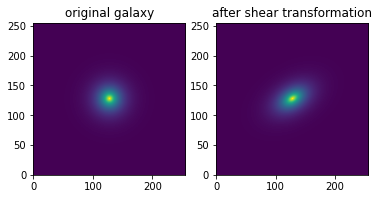

In [102]:
subplot(121)
imshow(image_original, origin='lower')
title('original galaxy')
subplot(122)
title('after shear transformation')
imshow(image_shear, origin='lower')

## Transformation using GalFlow

In [8]:
# Convert images and shear to tensors
img = tf.reshape(tf.convert_to_tensor(image_original, dtype=tf.float32),
                 [1, 256,256,1])
tfg1 = tf.convert_to_tensor(np.atleast_1d(g1), tf.float32)
tfg2 = tf.convert_to_tensor(np.atleast_1d(g2), tf.float32)

In [9]:
img_in = tf.placeholder(shape=[1, 256,256,1], dtype=tf.float32)
tfg1 = tf.placeholder(shape=[1,], dtype=tf.float32)
tfg2 = tf.placeholder(shape=[1,], dtype=tf.float32)

In [10]:
# Apply shear
res = gf.shear(img_in, tfg1, tfg2)

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
img_out = sess.run(res, feed_dict={img_in:image_original.reshape([1,256,256,1]),
                                  tfg1:np.atleast_1d(g1),
                                  tfg2:np.atleast_1d(g2)})

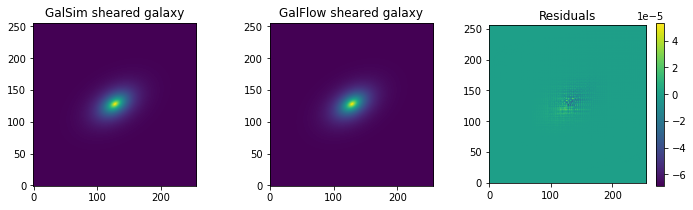

In [12]:
# Plot results
figure(figsize=[12,3])
subplot(131)
imshow(image_shear, origin='lower')
title('GalSim sheared galaxy')
subplot(132)
imshow(img_out[0,:,:,0], origin='lower')
title('GalFlow sheared galaxy')
subplot(133)
title('Residuals')
imshow((img_out[0,:,:,0] - image_shear), origin='lower'); colorbar();

## Let's try to differentiate the image with respect to shear

In [273]:
#def loss(shear, model, obs):
#    sheared_model = apply_shear2(model, shear[0], shear[1])
#    return tf.reduce_sum((sheared_model[0,:,:,0] - obs)**2)
shear = tf.Variable(tf.zeros((2,1)), trainable=True, dtype=tf.float32)
obs = tf.placeholder(shape=[1,256,256,1], dtype=tf.float32)
model = tf.placeholder(shape=[1,256,256,1], dtype=tf.float32)

In [274]:
#loss = 
sheared_model = gf.shear(model, shear[0], shear[1])
loss = tf.reduce_sum((sheared_model[0,:,:,0] - obs[0,:,:,0])**2)

In [275]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.1)

In [276]:
#for i in range(100):
for i in range(10):
    train = optimizer.minimize(loss, var_list=shear)

In [277]:
# initialize the variables
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [278]:
feed_dict = {obs:image_shear.reshape([1,256,256,1]), model:image_original.reshape([1,256,256,1])}

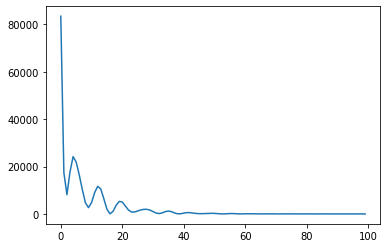

In [282]:
losses = []
for i in range(100):
    _, l, s_res = sess.run([train, loss, shear], feed_dict)
    losses.append(l)
    
plot(losses)

In [283]:
print(s_res)

[[0.10045832]
 [0.2002268 ]]
